In [1]:
%matplotlib inline
import sys
import matplotlib
import matplotlib.pyplot as plt
import glob, os
import numpy as np
from numpy.polynomial import polynomial as P
import re, csv
import pandas as pd
from math import sqrt
import seaborn as sns
from numpy.polynomial import polynomial as P
from scipy import stats
from scipy.stats import linregress
sns.set_style("whitegrid")
import librosa
import itertools
from IPython.display import Markdown, display, Audio
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
sys.path.insert(0, os.path.abspath('../../cleese'))
import cleese 

In [10]:
# Load Voimooo python wrapper
sys.path.insert(0, os.path.abspath('../../pyvoimooo/'))
import pyvoimooo as vmo
vmo.__version__

INFO: Wav write/read: Using libsndfile in Voimooo


'0.17.6'

# Stimulus generation, smile reverse correlation
ANR SEPIA (&copy; Gomot, Aucouturier, 2021-)

## Utilities

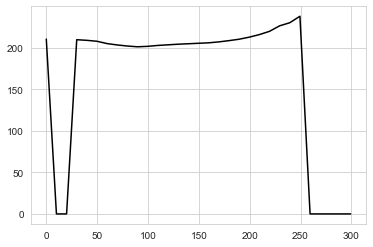

In [11]:
import pysptk

WIN_PITCH= 0.01
BOUNDS=[30,300]

def extract_pitch(x, sr, win, bounds, best_of_n =10):
    """Computes pitch on successive windows (size win, in samples), 
    and returns an array of pitch values (in Hz) and array of window time positions (in ms).
    bounds = [min_f0,max_f0] in which the pitch should be searched.
    """
    hop_size = np.floor(sr * win)
    min_f0, max_f0 = bounds
    
    # for some reason, the algorithm is stochastic and may underselect pitched areas
    # we take the best_of_n run returning most nb of non zero values
    pitch = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_size, min=min_f0, max=max_f0, otype=1, threshold=0.3)
    non_zeros = len(np.where(pitch > 0)[0])
    for run in np.arange(0,best_of_n): 
        new_run = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_size, min=min_f0, max=max_f0, otype=1, threshold=0.3)
        run_non_zeros = len(np.where(new_run > 0)[0])
        if (run_non_zeros >= non_zeros): 
            pitch = new_run
            non_zeros = run_non_zeros
            
    times = 1000*np.arange(len(pitch))*hop_size/sr
    return times,np.array(pitch) 

wave_in, sr = librosa.load('sounds\\base_sounds\\gomot_a.wav')
times,pitch = extract_pitch(wave_in,sr,WIN_PITCH,BOUNDS, best_of_n=10)
plt.plot(times,pitch,'k')

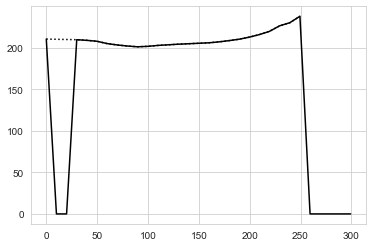

In [12]:
import math
def interpolate_pitch(pitch, method, start_value, end_value): 
    """Interpolate zeros in pitch series. Method = spline (order-3 polynomial), linear or none. 
    Provide start_value, end_value to fix bounds. 
    """
    if method == 'spline' :
        order = 3
        pitch_interp = np.copy(pitch)
        pitch_interp[0:1] = start_value #math.log(spline_start)
        pitch_interp[-2:] = end_value # math.log(spline_end)
        pitch_interp = np.array(pd.Series(pitch_interp).interpolate(method='polynomial', order=order))
    
    elif method == 'linear' :
        xp=np.where(np.invert(list(map(math.isnan, pitch))))[0]
        fp=np.array(pitch)[np.where(np.invert(list(map(math.isnan, pitch))))]
        pitch_interp = np.interp(x=range(len(pitch)),
                                 xp=xp,
                                 fp=fp)
    elif method == 'none' :
        pitch_interp = np.copy(pitch)
        pitch_interp[np.nonzero(np.isnan(pitch))] = 0
    
    return pitch_interp

wave_in, sr = librosa.load('sounds\\base_sounds\\gomot_a.wav')
times, pitch = extract_pitch(wave_in,sr,WIN_PITCH, BOUNDS)
plt.plot(times,pitch,'k')
pitch[np.where(pitch == 0)] = np.nan
# trim beginning and end nans
notnans = np.flatnonzero(~np.isnan(pitch))
if notnans.size:
    pitch = pitch[notnans[0]: notnans[-1]+1]
    times = times[notnans[0]: notnans[-1]+1]
else: 
    pitch = times = []
# interpolate nans
start_value = end_value = np.mean(pitch[np.nonzero(~np.isnan(pitch))])
pitch_interp = interpolate_pitch(pitch,
                                 method='linear',
                                 start_value = start_value, 
                                 end_value = end_value)
plt.plot(times,pitch_interp,'k:')

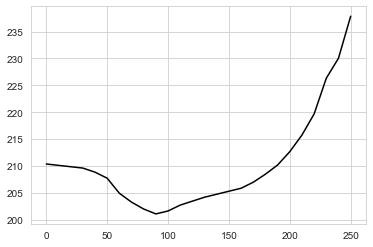

In [13]:
def extract_pitch_interp(wave_in, sr, method='linear'): 
    
    times, pitch = extract_pitch(wave_in,sr, win=WIN_PITCH, bounds=BOUNDS)
    pitch[np.where(pitch == 0)] = np.nan
    
    # trim beginning and end nans
    notnans = np.flatnonzero(~np.isnan(pitch))
    if notnans.size:
        pitch = pitch[notnans[0]: notnans[-1]+1]
        times = times[notnans[0]: notnans[-1]+1]
    else: 
        pitch = times = []
       
    # interpolate nans
    start_value = end_value = np.mean(pitch[np.nonzero(~np.isnan(pitch))])
    pitch_interp = interpolate_pitch(pitch,
                                 method=method,
                                 start_value = start_value, 
                                 end_value = end_value)
    
    return times, pitch_interp

wave_in, sr = librosa.load('sounds\\base_sounds\\gomot_a.wav')
times, pitch_interp = extract_pitch_interp(wave_in, sr, method='linear')
plt.plot(times,pitch_interp,'k')

## Flatten prosody

Original file:

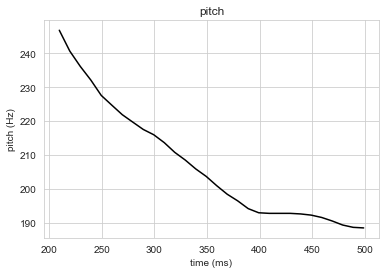

In [18]:
# original file
input_file = 'sounds\\base_sounds\\tts_a.wav'
wave_in,sr, fmt = cleese.wavRead(input_file)

display(Markdown("Original file:"))
times,pitch = extract_pitch_interp(wave_in,sr, method='linear')
_=plt.plot(times,pitch,'k');
_=plt.title('pitch')
_=plt.ylabel('pitch (Hz)')
_=plt.xlabel('time (ms)')
#plt.ylim([200,250])
Audio(data=wave_in, rate=sr)


Text(0.5, 1.0, 'pitch')

Text(0, 0.5, 'pitch (Hz)')

Text(0.5, 0, 'time (ms)')

(200.0, 250.0)

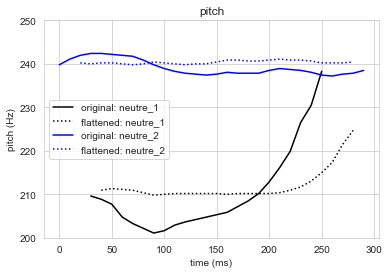

In [54]:
# original file
input_file = 'sounds\\base_sounds\\neutre_1.wav'
wave_in,sr, fmt = cleese.wavRead(input_file)
times,pitch = extract_pitch_interp(wave_in,sr, method='linear')
plt.plot(times,pitch,'k', label='original: neutre_1');

input_file = 'sounds\\base_sounds\\neutre_1_flat.wav'
wave_in,sr, fmt = cleese.wavRead(input_file)
times,pitch = extract_pitch_interp(wave_in,sr, method='linear')
plt.plot(times,pitch,'k:', label='flattened: neutre_1');

input_file = 'sounds\\base_sounds\\neutre_2.wav'
wave_in,sr, fmt = cleese.wavRead(input_file)
times,pitch = extract_pitch_interp(wave_in,sr, method='linear')
_=plt.plot(times,pitch,'b', label='original: neutre_2');

input_file = 'sounds\\base_sounds\\neutre_2_flat.wav'
wave_in,sr, fmt = cleese.wavRead(input_file)
times,pitch = extract_pitch_interp(wave_in,sr, method='linear')
_=plt.plot(times,pitch,'b:', label='flattened: neutre_2');


plt.title('pitch')
plt.ylabel('pitch (Hz)')
plt.xlabel('time (ms)')
plt.ylim([200,250])
plt.legend(loc=6)
plt.savefig('pitch.jpg', bbox_inches='tight')

To flatten this existing contour, we construct a custom breakpoint function that passes through the pitch shift values needed to shift the contour down to a constant pitch value, arbitrarily set here at 130Hz. 

We then apply this custom BPF to the original file, using ```vmo.pitch_scaling_snm(wave_in, sr, dpss=np.row_stack((bpf_times, bpf_shifts)))```. \
An alternative is to use ```cleese.process(soundData=wave_in, configFile=config_file, sr=sr, BPF=bpf)``` but the relatively large scaling involved in flattening files typically doesn't work very well with the simple vocoder of CLEESE v1. 

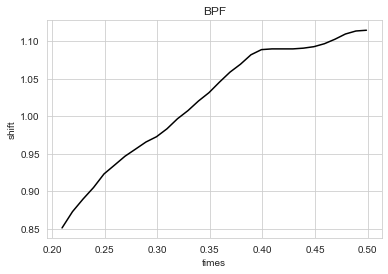

Transformed file:

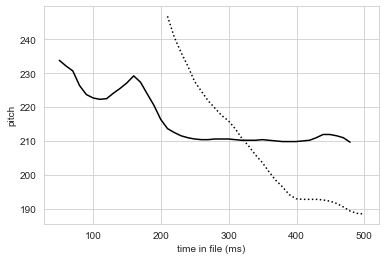

In [20]:
MEAN_PITCH =210

hop = 1
bpf_times = times[0::hop]/1000
bpf_shifts = MEAN_PITCH/pitch[0::hop]
_=plt.plot(bpf_times, bpf_shifts, 'k')
_=plt.title('BPF')
_=plt.xlabel('times')
_=plt.ylabel('shift')
plt.show()

wave_in,sr =  vmo.readwav(input_file)
wave_out, tts, f0s = vmo.pitch_scaling_snm(wave_in, sr, dpss=np.row_stack((bpf_times, bpf_shifts)))

# display transformed file
display(Markdown("Transformed file:"))
Audio(data=wave_out, rate=sr)
times_f, pitch_f = extract_pitch_interp(wave_out,sr, method='linear')
_=plt.plot(times, pitch, 'k:')
_=plt.plot(times_f, pitch_f, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')

input_file_flat = os.path.splitext(input_file)[0]+'_flat.wav'
vmo.writewav(input_file_flat, sr, wave_out)

## Visualize enveloppes and formants

In [11]:
def spectral_env(wave_in, sr, aggregator=lambda x: np.mean(x,0)):
    # extract mean spectral envelope from wave_file using the vmo smile transform
    syn, tts, f0s, envs_ori, envs_new  = vmo.smile(wave_in,sr, alpha=1.)
    env = aggregator(envs_ori)
    f = np.linspace(0,sr/2,len(env))
    return f,env 



In [12]:
from scipy.signal import argrelextrema

def plot_enveloppe_formants(f, env, color='k', y_shift=0.6, label=''): 
    
    # normalize amplitude & log
    env = np.log(env)
    env = (env - np.min(env))
    env = (env / np.max(env))
    
    # extract formants as enveloppe extrema
    peaks = f[argrelextrema(env,np.greater)]
    formants = peaks[(500<peaks) & (peaks<10000)]
    formants = formants[[0,1,2,3]]
    
    plt.plot(f, env, color, label=label);
    plt.xscale('log');

    for id,formant in enumerate(formants):
        plt.plot([formant,formant],[0, 1], ':',color=color, alpha=0.3);
        plt.text(x=formant,
                 y=y_shift-id*0.05,
                 s=' %d'%formant,
                 size=10,
                 ha='left', 
                 color=color)
    #print(formant)
    



Compare start and end enveloppe in original in flattened

(800, 8000)

Text(0.5, 0, 'f(Hz)')

Text(0, 0.5, 'log spectrum (dB)')

Text(0.5, 1.0, 'Comparison of original and flattened enveloppe: neutre_2')

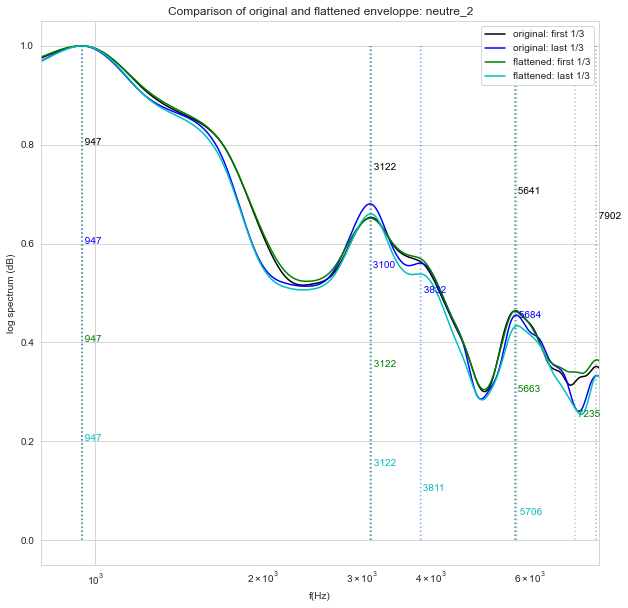

In [55]:
fig,ax = plt.subplots(figsize=(10,10))

base_sound="neutre_2"

# extract mean enveloppe
wave_in,sr =  vmo.readwav('sounds\\base_sounds\\%s.wav'%base_sound)
f, env = spectral_env(wave_in,sr, aggregator=lambda x: np.mean(x[0:int(len(x)/3)],0))
plot_enveloppe_formants(f, env, color='k',y_shift=0.8,label='original: first 1/3')

wave_in,sr =  vmo.readwav('sounds\\base_sounds\\%s.wav'%base_sound)
f, env = spectral_env(wave_in,sr, aggregator=lambda x: np.mean(x[int(2*len(x)/3):],0))
plot_enveloppe_formants(f, env, color='b',y_shift=0.6,label='original: last 1/3')

wave_in,sr =  vmo.readwav('sounds\\base_sounds\\%s_flat.wav'%base_sound)
f, env = spectral_env(wave_in,sr, aggregator=lambda x: np.mean(x[0:int(len(x)/3)],0))
plot_enveloppe_formants(f, env, color='g',y_shift=0.4,label='flattened: first 1/3')

wave_in,sr =  vmo.readwav('sounds\\base_sounds\\%s_flat.wav'%base_sound)
f, env = spectral_env(wave_in,sr, aggregator=lambda x: np.mean(x[int(2*len(x)/3):],0))
plot_enveloppe_formants(f, env, color='c',y_shift=0.2,label='flattened: last 1/3')


plt.xlim([800,8000])
plt.xlabel('f(Hz)')
plt.ylabel('log spectrum (dB)')
plt.legend(loc=1)
plt.title("Comparison of original and flattened enveloppe: %s"%base_sound)
plt.savefig('%s_stability.jpg'%base_sound, bbox_inches='tight')

(800, 8000)

Text(0.5, 0, 'f(Hz)')

Text(0, 0.5, 'log spectrum (dB)')

Text(0.5, 1.0, 'Comparison of original and flattened enveloppe: neutre_2')

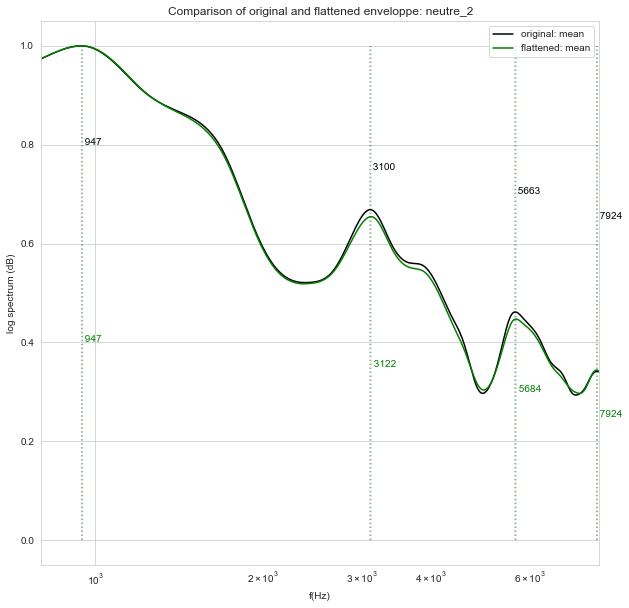

In [45]:
fig,ax = plt.subplots(figsize=(10,10))

base_sound="neutre_2"

# extract mean enveloppe
wave_in,sr =  vmo.readwav('sounds\\base_sounds\\%s.wav'%base_sound)
f, env = spectral_env(wave_in,sr)
plot_enveloppe_formants(f, env, color='k',y_shift=0.8,label='original: mean')

wave_in,sr =  vmo.readwav('sounds\\base_sounds\\%s_flat.wav'%base_sound)
f, env = spectral_env(wave_in,sr)
plot_enveloppe_formants(f, env, color='g',y_shift=0.4,label='flattened: mean')

plt.xlim([800,8000])
plt.xlabel('f(Hz)')
plt.ylabel('log spectrum (dB)')
plt.legend(loc=1)
plt.title("Comparison of original and flattened enveloppe: %s"%base_sound)
plt.savefig('%s.jpg'%base_sound, bbox_inches='tight')

## Randomize spectra w/ CLEESE

In [6]:
# generate random files
input_file = "sounds\\base_sounds\\tts_a_flat.wav"
config_file = "random_eq_profile.py"
cleese.process(soundData=input_file, configFile=config_file)

./sounds/
eq variation 1/1000
eq variation 2/1000
eq variation 3/1000
eq variation 4/1000
eq variation 5/1000
eq variation 6/1000
eq variation 7/1000
eq variation 8/1000
eq variation 9/1000
eq variation 10/1000
eq variation 11/1000
eq variation 12/1000
eq variation 13/1000
eq variation 14/1000
eq variation 15/1000
eq variation 16/1000
eq variation 17/1000
eq variation 18/1000
eq variation 19/1000
eq variation 20/1000
eq variation 21/1000
eq variation 22/1000
eq variation 23/1000
eq variation 24/1000
eq variation 25/1000
eq variation 26/1000
eq variation 27/1000
eq variation 28/1000
eq variation 29/1000
eq variation 30/1000
eq variation 31/1000
eq variation 32/1000
eq variation 33/1000
eq variation 34/1000
eq variation 35/1000
eq variation 36/1000
eq variation 37/1000
eq variation 38/1000
eq variation 39/1000
eq variation 40/1000
eq variation 41/1000
eq variation 42/1000
eq variation 43/1000
eq variation 44/1000
eq variation 45/1000
eq variation 46/1000
eq variation 47/1000
eq variation

eq variation 379/1000
eq variation 380/1000
eq variation 381/1000
eq variation 382/1000
eq variation 383/1000
eq variation 384/1000
eq variation 385/1000
eq variation 386/1000
eq variation 387/1000
eq variation 388/1000
eq variation 389/1000
eq variation 390/1000
eq variation 391/1000
eq variation 392/1000
eq variation 393/1000
eq variation 394/1000
eq variation 395/1000
eq variation 396/1000
eq variation 397/1000
eq variation 398/1000
eq variation 399/1000
eq variation 400/1000
eq variation 401/1000
eq variation 402/1000
eq variation 403/1000
eq variation 404/1000
eq variation 405/1000
eq variation 406/1000
eq variation 407/1000
eq variation 408/1000
eq variation 409/1000
eq variation 410/1000
eq variation 411/1000
eq variation 412/1000
eq variation 413/1000
eq variation 414/1000
eq variation 415/1000
eq variation 416/1000
eq variation 417/1000
eq variation 418/1000
eq variation 419/1000
eq variation 420/1000
eq variation 421/1000
eq variation 422/1000
eq variation 423/1000
eq variati

eq variation 756/1000
eq variation 757/1000
eq variation 758/1000
eq variation 759/1000
eq variation 760/1000
eq variation 761/1000
eq variation 762/1000
eq variation 763/1000
eq variation 764/1000
eq variation 765/1000
eq variation 766/1000
eq variation 767/1000
eq variation 768/1000
eq variation 769/1000
eq variation 770/1000
eq variation 771/1000
eq variation 772/1000
eq variation 773/1000
eq variation 774/1000
eq variation 775/1000
eq variation 776/1000
eq variation 777/1000
eq variation 778/1000
eq variation 779/1000
eq variation 780/1000
eq variation 781/1000
eq variation 782/1000
eq variation 783/1000
eq variation 784/1000
eq variation 785/1000
eq variation 786/1000
eq variation 787/1000
eq variation 788/1000
eq variation 789/1000
eq variation 790/1000
eq variation 791/1000
eq variation 792/1000
eq variation 793/1000
eq variation 794/1000
eq variation 795/1000
eq variation 796/1000
eq variation 797/1000
eq variation 798/1000
eq variation 799/1000
eq variation 800/1000
eq variati

## Change BPF file format

Change format of BPF files: by default, ```eq``` transforms are time-variable, so not stored as ```f,gain``` pairs. Here, only one ```t```, so we change the bpf .txt format to match the pair format, as expected in revcor experiment code. 

In [22]:
# merge metadata files
output_folder = 'sounds/2022-01-24_06-41-56'
bpf_files = glob.glob(output_folder+'/eq/*.txt')

for bpf_file in bpf_files: 
    # eq data
    bpf_data = np.loadtxt(bpf_file)
    # reshape as two-column dataframe
    data_df = pd.DataFrame.from_dict({'f':bpf_data[2::2],
                           'eq':bpf_data[3::2]})
    # replace original file
    os.remove(bpf_file)
    data_df.to_csv(bpf_file, index=False) 
    
    